In [1]:
#%pylab nbagg
%matplotlib inline
#%matplotlib widget

In [64]:
import numpy as np
import matplotlib.pyplot as plt   

from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA

from mpl_toolkits import mplot3d

import scipy
import scipy.io as io
from scipy import stats
from scipy import signal as sig
from scipy.signal import argrelextrema

#import importlib
#import Time_delay_embedding
#importlib.reload(Time_delay_embedding)

import AAL_Atlas_ordclu as AAL
import Preprocess_Signal as PPS
import Time_delay_embedding as TDE

import pickle

def save_obj(obj, name ):
    with open('/Users/giovanni/Desktop/Neuro/Pierpaolo-MEG/ArticleResults_I_py2/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('/Users/giovanni/Desktop/Neuro/Pierpaolo-MEG/ArticleResults_I_py2/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [3]:
# MUTUAL INFORMATION SCORE
from sklearn.metrics import mutual_info_score
def calc_MI(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

In [6]:
def model_func_lin(x, a, b):
    return a * x**8 + b

In [5]:
#from scipy.integrate import simps
from numpy import trapz
from scipy.optimize import curve_fit

In [4]:
nsubs=47
nregions=78
#original sampling at 1024 Hz. Data downsampled to 256 Hz.
f_MEG=1024
f_meg=256
n_twin=10
tmin=10*f_MEG*n_twin

nedges=int(nregions**2/2-nregions/2)

iTriup= np.triu_indices(nregions,k=1)  #nedges=len(iTriup[0])

#Edge to Nodes
dic={}
for e in range(nedges):
    dic['%d'%e]=[iTriup[0][e],iTriup[1][e]]

# DATASET EXTRACTION
### ##################################
# 1.0)  Select all consecutive windows of 10 sec activity for each subject
### ##################################

In [7]:
import scipy.io
#path='/Users/giovanni/Desktop/Neuro/Pierpaolo-MEG/'
path='/Users/giovanni/Desktop/Neuro/Pierpaolo-MEG/'
tempi = scipy.io.loadmat(path+'tempi_pz_melbourne.mat')

In [8]:
import scipy.io
ff = scipy.io.loadmat(path+'dti_naples_1009.mat')
SCs=np.mean(ff['D'][:78,:78,:],axis=2)

In [9]:
import h5py
f = h5py.File(path+'/serie_Melbourne.mat','r')
struArray = f['D']

In [28]:
#import scipy.io
#ff = scipy.io.loadmat(path+'DATA/10SecWin/MIS_Edges_DecayRate_OldOrd.mat')

In [10]:
tii=tempi['D'][0][0][0]

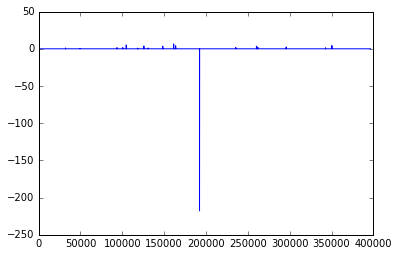

In [11]:
plt.plot(np.diff(tii));plt.show()

In [12]:
intervals={}
for i in range(nsubs):
    ti=tempi['D'][0][i][0] #tempi for subject i
    intervals['%d'%i]=np.concatenate((np.asarray([0]),np.where(np.abs(np.diff(ti))>0.01)[0],np.asarray([len(ti)]))) #where are the intervals

In [13]:
intervals['0']

array([     0,  32209,  49410,  93621, 100608, 104739, 118408, 125775,
       130855, 148367, 161376, 163752, 192290, 235650, 260297, 261861,
       295820, 342847, 350418, 396772])

In [66]:
np.diff(intervals['%d'%0].astype('float'))/f_MEG

array([31.45410156, 16.79785156, 43.17480469,  6.82324219,  4.03417969,
       13.34863281,  7.19433594,  4.9609375 , 17.1015625 , 12.70410156,
        2.3203125 , 27.86914062, 42.34375   , 24.06933594,  1.52734375,
       33.16308594, 45.92480469,  7.39355469, 45.26757812])

In [15]:
maxint=np.zeros(nsubs)
sizei=np.zeros(nsubs)
for i in range(nsubs):
    maxint[i]=np.diff(intervals['%d'%i]).max()  
    sizei[i]=np.sum(np.diff(intervals['%d'%i]))

In [16]:
Nsubs=47

In [17]:
np.diff(intervals['%d'%0])

array([32209, 17201, 44211,  6987,  4131, 13669,  7367,  5080, 17512,
       13009,  2376, 28538, 43360, 24647,  1564, 33959, 47027,  7571,
       46354])

In [21]:
consecutives={}
w_len_sec=10
for i in range(Nsubs):
    windows=[]
    for ij, j in enumerate(np.diff(intervals['%d'%i])):
        nj=int(j/(w_len_sec*f_MEG))
        if nj!=0:            
            for k in range(nj):
                tlimi=intervals['%d'%i][ij]+k*w_len_sec*f_MEG
                tlimf=intervals['%d'%i][ij]+k*w_len_sec*f_MEG+w_len_sec*f_MEG
                wstar=f[struArray[i, 0]][tlimi:tlimf,:nregions]
                wstar=wstar[::4] #downsampling
                windows.append(wstar)
    consecutives['%d'%i]=np.asarray(windows)

In [22]:
nwinds=np.zeros(Nsubs)
for i in range(Nsubs):
    nwinds[i]=len(consecutives['%d'%i])

In [23]:
nwinds

array([30., 29., 33., 31., 26., 19., 18., 26., 12., 26., 19.,  5., 33.,
       18., 17.,  4., 18., 10., 26., 26.,  3., 12., 23., 28., 17., 20.,
       22., 22., 38., 22., 32., 35., 16., 66., 33., 20., 16., 22., 24.,
       31., 17., 27., 35., 19., 30., 27., 36.])

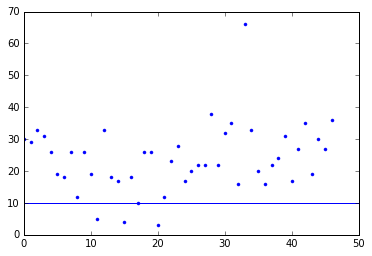

In [24]:
plt.plot(nwinds,'.');plt.axhline(10)

In [25]:
nsub=len(np.where(nwinds>=10)[0])
nsub

44

In [26]:
consecutives['%d'%0].shape

(30, 2560, 78)

In [28]:
save_obj(consecutives,'consecutives')

In [29]:
consecutives=load_obj('consecutives')

In [30]:
consecutives['0'].shape

(30, 2560, 78)

In [31]:
#Find joint probability distribution for given bin number
signal=consecutives['0'][0]
lag=5
tau_max = 128 
sigroll=np.roll(signal, -lag, axis=0)
sigroll[:,0][:-tau_max].shape
c_xy = np.histogram2d(signal[:,0][:-tau_max], sigroll[:,0][:-tau_max], 64)[0]
mi = mutual_info_score(None, None, contingency=c_xy)

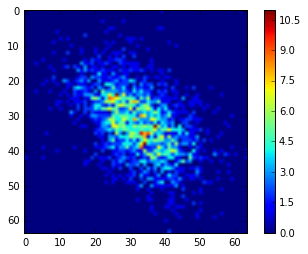

In [32]:
plt.imshow(c_xy);plt.colorbar()

# 1.1) For each subject select 10 epochs of (10 sec) activity. In each of the 44x10 trials extract the MIS of each edge co-activation signal. 
### (44 subjects, 3 are excluded since they do not have 10 consecutive epochs)

In [78]:
#The first minima of the mutual information score beteewn each region and its time lagged version form a multimodal distribution.
#Frontal nodes have minima occurring at later times. Information is preserved for longer times.
nedges=int(nregions**2/2-nregions/2)
tau_max = 128 
ntwin=10
nbin=64
MIS_edges={}
for i, sub in enumerate(np.where(nwinds>=ntwin)[0]):
    EMIS_wind=np.zeros((ntwin, tau_max, nedges))
    for iw in range(ntwin):
        megwin=consecutives['%d'%sub][iw][:,AAL.Neword_lab] 
        Zmeg=stats.zscore(megwin,axis=0)
        Edges=Zmeg[:,iTriup[0]]*Zmeg[:,iTriup[1]]
        EMIS_wind[iw]=TDE.TauLag(Edges, tau_max, nedges, 'MI', nbin)
    MIS_edges['%d'%i]=EMIS_wind

In [79]:
save_obj(MIS_edges,'MIS_edges')

In [89]:
# IMPORT MIS_nodes DATA (The edges are in the wrong order, so I will correct it later)

MIS_edges=load_obj('MIS_edges')

In [80]:
nedges=int(nregions**2/2-nregions/2)

In [81]:
MIS_edges['0'][0].shape

(128, 3003)

# 1.2) In each trial and for each edge find the first minimum of the AMI decay-profile. We use a linear fit on the last 80 points to find where the AMI stabilizes. Then we evaluate the first time that the AMI decay profile approaches the fitted line (in a range below a given threshold)

In [123]:
minima_edges_Single=np.zeros((44,10,nedges))
minima_edges_Single_int=np.zeros((44,10,nedges))
x = np.linspace(0., 127., 128)
p1=(0.,0.)
x2 = np.linspace(0., 127., 128)

for i in range(44):
    for j in range(10):
        for ie in range(nedges):
            numero=MIS_edges['%d'%i][j][:,ie]
            denumero=np.max(MIS_edges['%d'%i][j][:,ie])
            y=numero/denumero
            # curve fit
            opt1, pcov1 = curve_fit(model_func_lin, x[30:], y[30:], p1)
            a1, b1 = opt1
            
            g=model_func_lin(x, a1, b1)
            idx = np.argwhere(y - g<0.005).flatten()
            
            minima_edges_Single[i][j,ie]=x[idx[0]]  
            minima_edges_Single_int[i][j,ie]=trapz(y[:int(x[idx[0]])], dx=1) 

In [103]:
#io.savemat(path+'/ArticleResults_I/minima_edges_Single.mat', {'C':minima_edges_Single})

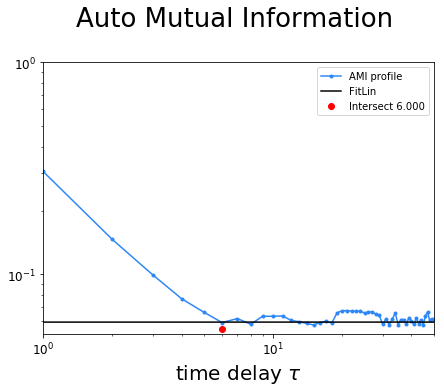

In [93]:
plt.figure(figsize=(7,5))
plt.title('Auto Mutual Information \n',fontsize=26)
plt.loglog(y,'.-',color=([0.1785, 0.5296, 0.9677]),label='AMI profile')
x2 = np.linspace(0, 127, 128)
plt.loglog(x2,model_func_lin(x2, a1, b1),'k-',label='FitLin')
plt.loglog(x2[idx[0]], 0.055, 'ro',label='Intersect %.3f'%x2[idx[0]])
plt.ylim((0,1))
plt.xlim((0,50))
plt.xlabel('time delay $\\tau$',fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
plt.show()

## 1.2.1) Since the order of the regions was 'wrong' we need to rotate back the arrays to the 'old' order of Pierpaolo's dataset. Also, in order to make the circle plots later we need to find the 'new' order.

In [155]:
minima_edges_Single=io.loadmat(path+'/ArticleResults_I/minima_edges_Single.mat')

In [156]:
minima_edges_Single=minima_edges_Single['C']

In [157]:
minima_edgesWrong=np.mean(minima_edges_Single,axis=1)

In [158]:
minima_edgesWrong.shape

(44, 3003)

In [159]:
minima_edges_Single.shape

(44, 10, 3003)

In [160]:
#Here we adjust the wrong indices
Oldord_lab=np.asarray([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14, 15, 16,
       17, 18, 19, 20,33,34,35,36,37,38, 21,22,
       23, 24, 25, 26, 27,28, 29, 30, 31, 32, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59,72,73,74,75,76,77, 60, 61, 62, 63, 64, 65, 66,67,68,69,70,71])

WrongLabels=np.asarray(['Rectus_L','Olfactory_L','Frontal_Sup_Orb_L','Frontal_Med_Orb_L',
 'Frontal_Mid_Orb_L','Frontal_Inf_Orb_L','Frontal_Sup_L','Frontal_Mid_L','Frontal_Inf_Oper_L',
 'Frontal_Inf_Tri_L','Frontal_Sup_Medial_L','Supp_Motor_Area_L','Paracentral_Lobule_L','Precentral_L',
 'Rolandic_Oper_L','Postcentral_L','Parietal_Sup_L','Parietal_Inf_L','SupraMarginal_L','Angular_L',
 'Precuneus_L','Heschl_L','Temporal_Sup_L','Temporal_Mid_L','Temporal_Inf_L','Temporal_Pole_Sup_L','Temporal_Pole_Mid_L',
 'ParaHippocampal_L','Cingulum_Ant_L','Cingulum_Mid_L','Cingulum_Post_L','Insula_L','Occipital_Sup_L','Occipital_Mid_L',
 'Occipital_Inf_L','Calcarine_L','Cuneus_L','Lingual_L','Fusiform_L','Rectus_R','Olfactory_R','Frontal_Sup_Orb_R',
 'Frontal_Med_Orb_R','Frontal_Mid_Orb_R','Frontal_Inf_Orb_R','Frontal_Sup_R','Frontal_Mid_R','Frontal_Inf_Oper_R',
 'Frontal_Inf_Tri_R','Frontal_Sup_Medial_R','Supp_Motor_Area_R','Paracentral_Lobule_R','Precentral_R','Rolandic_Oper_R',
 'Postcentral_R','Parietal_Sup_R','Parietal_Inf_R','SupraMarginal_R','Angular_R','Precuneus_R','Heschl_R','Temporal_Sup_R',
 'Temporal_Mid_R','Temporal_Inf_R','Temporal_Pole_Sup_R','Temporal_Pole_Mid_R','ParaHippocampal_R','Cingulum_Ant_R',
 'Cingulum_Mid_R','Cingulum_Post_R','Insula_R','Occipital_Sup_R','Occipital_Mid_R','Occipital_Inf_R',
 'Calcarine_R','Cuneus_R','Lingual_R', 'Fusiform_R'])

NewLabels=np.asarray(AAL.SC_labels)

OldOrdLabels=np.asarray(AAL.SC_labels)[Oldord_lab]

NewtoOld=np.zeros((nregions),dtype=int)
for i in range(nregions):
    NewtoOld[i]=np.where(NewLabels==OldOrdLabels[i])[0][0]
    
#NewLabels[NewtoOld]

WrongtoOld=np.zeros((nregions),dtype=int)
for i in range(nregions):
    WrongtoOld[i]=np.where(WrongLabels==OldOrdLabels[i])[0][0]
    
#WrongLabels[WrongtoOld]

WrongtoNew=np.zeros((nregions),dtype=int)
for i in range(nregions):
    WrongtoNew[i]=np.where(WrongLabels==NewLabels[i])[0][0]

#WrongLabels[WrongtoNew]

OldtoNew=np.zeros((nregions),dtype=int)
for i in range(nregions):
    OldtoNew[i]=np.where(OldOrdLabels==NewLabels[i])[0][0]

In [161]:
EminimaWrong=np.mean(minima_edgesWrong,axis=0)
tri = np.zeros((78, 78))
tri[np.triu_indices(78, 1)] = EminimaWrong
MiniMatWrong=tri+tri.T
MiniMatNewOrd=MiniMatWrong[np.ix_(WrongtoNew,WrongtoNew)]

In [162]:
MiniMatOrdOld=MiniMatNewOrd[np.ix_(NewtoOld,NewtoOld)]

In [163]:
EminimaNew=MiniMatNewOrd[np.triu_indices(78, 1)]

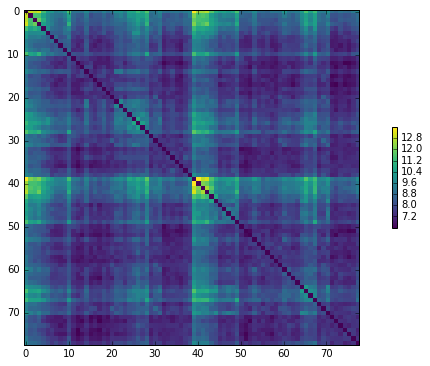

In [164]:
# Let us plot the matrix of the minima

plt.figure(figsize=(12,6))
plt.imshow((MiniMatNewOrd),cmap='viridis',interpolation='nearest',vmin=np.sort(np.unique(MiniMatNewOrd))[1]);plt.colorbar(shrink=0.3)

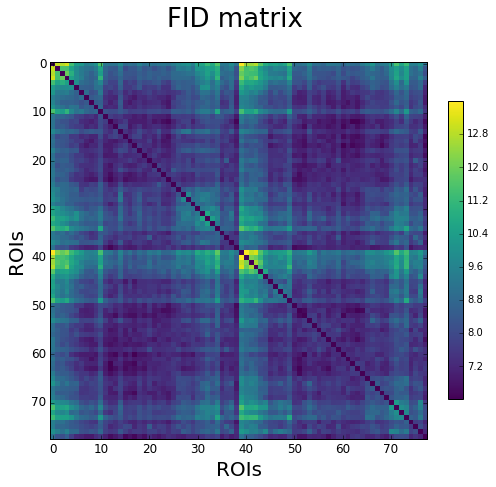

In [166]:
plt.figure(figsize=(7,7))
plt.title('FID matrix \n',fontsize=26)
#plt.subplot(121);plt.imshow(MiniMat,vmin=6.5);plt.colorbar(shrink=0.3)
plt.imshow(MiniMatOrdOld,cmap='viridis',interpolation='nearest',vmin=np.sort(np.unique(MiniMatNewOrd))[1]);
cb = plt.colorbar(shrink=0.7,fraction=0.05)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('ROIs',fontsize=20)
plt.ylabel('ROIs',fontsize=20)
plt.tight_layout()
plt.savefig('aa.pdf')

In [112]:
#io.savemat(path+'MiniMatOrdOld.mat', {'C':MiniMatOrdOld})

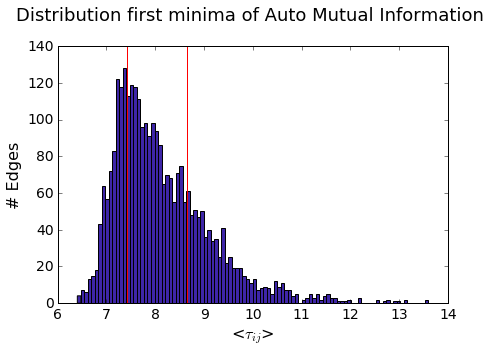

In [76]:
plt.figure(figsize=(7,5));plt.hist(EminimaNew, bins=100,color=([0.2422, 0.1504, 0.6603]));
plt.title('Distribution first minima of Auto Mutual Information \n',fontsize=18)
plt.axvline(np.percentile(EminimaNew,25,interpolation='midpoint'),color='r')
plt.axvline(np.percentile(EminimaNew,75,interpolation='midpoint'),color='r')
plt.ylabel('# Edges',fontsize=16)
plt.xlabel('<$ \\tau_{ij}$>',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig('DistributionMEG.pdf')
plt.show()

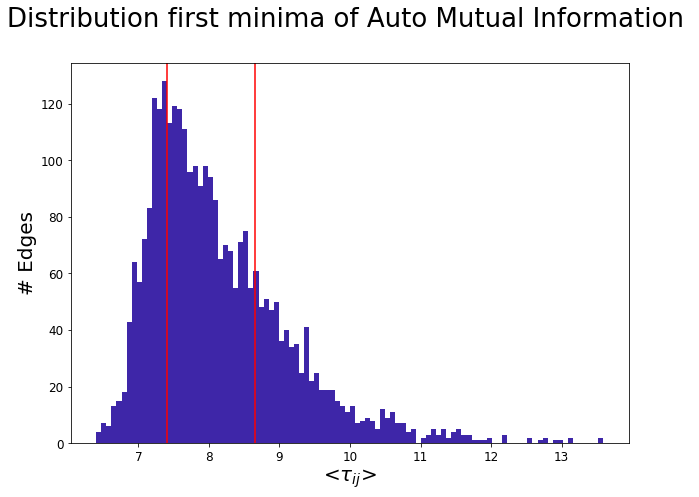

In [108]:
plt.figure(figsize=(10,7));plt.hist(EminimaNew, bins=100,color=([0.2422, 0.1504, 0.6603]));
plt.title('Distribution first minima of Auto Mutual Information \n',fontsize=26)
plt.axvline(np.percentile(EminimaNew,25,interpolation='midpoint'),color='r')
plt.axvline(np.percentile(EminimaNew,75,interpolation='midpoint'),color='r')
plt.ylabel('# Edges',fontsize=20)
plt.xlabel('<$ \\tau_{ij}$>',fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# 1.3) Make circle plots with fastest and slowest decaying edges

In [109]:
# Betweeness Centrality in Fast and Slow decaying subnetworks and in the MultiStorage Core

BCentrality_fast_oldord=np.asarray([13,17,21,22,23,24,26,51,52,53,55,56,57,58,59,60,61,62,64,65])-1
BCentrality_slow_oldord=np.asarray([1,2,15,28,29,32,33,35,36,40,41,43,67,68,69,74])-1
MPC_oldord=np.asarray([9,48,76,49,11,50,45,44,37,19,70,5,10,54,66,39])-1

In [56]:
np.where(EminimaNew<7.1)[0].shape

(277,)

In [57]:
# 10% fastest
weigh=np.zeros(nedges);weigh[np.where(EminimaNew<7.1)]=1

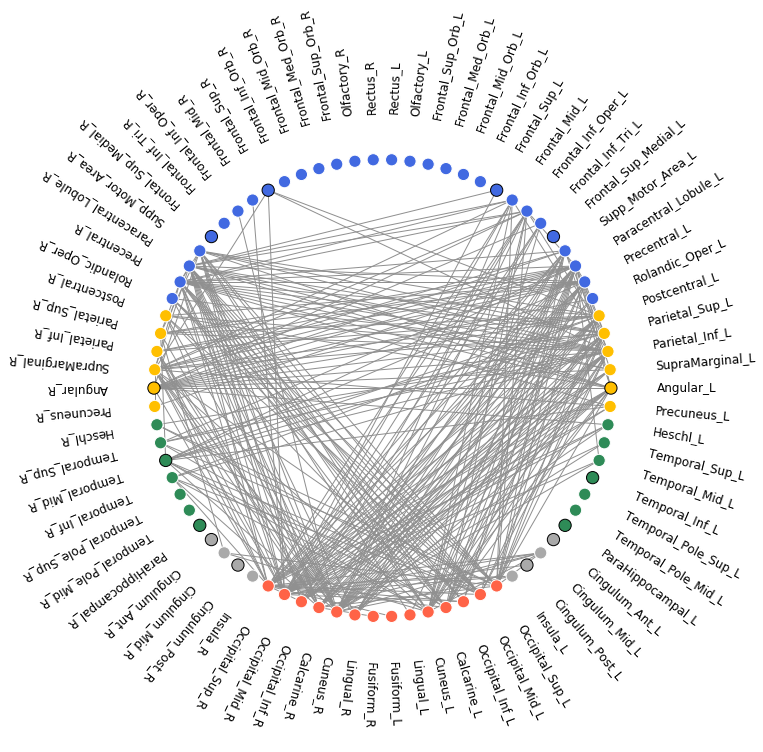

In [65]:
AAL.drawgraph(AAL.SC,weigh)

In [68]:
np.where(EminimaNew>9.5)[0].shape

(278,)

In [69]:
weigh=np.zeros(nedges);weigh[np.where(EminimaNew>9.5)]=1

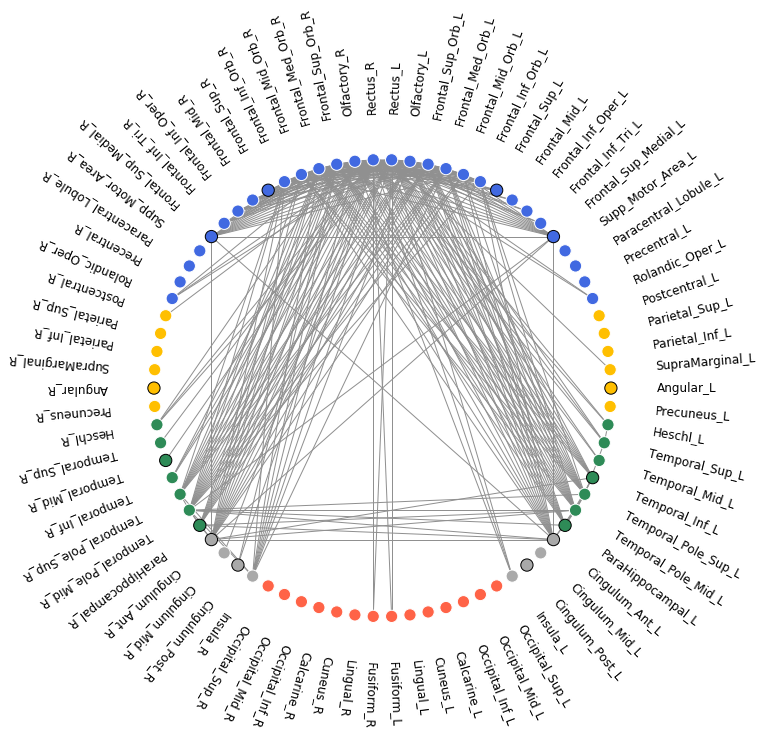

In [70]:
AAL.drawgraph(AAL.SC,weigh)

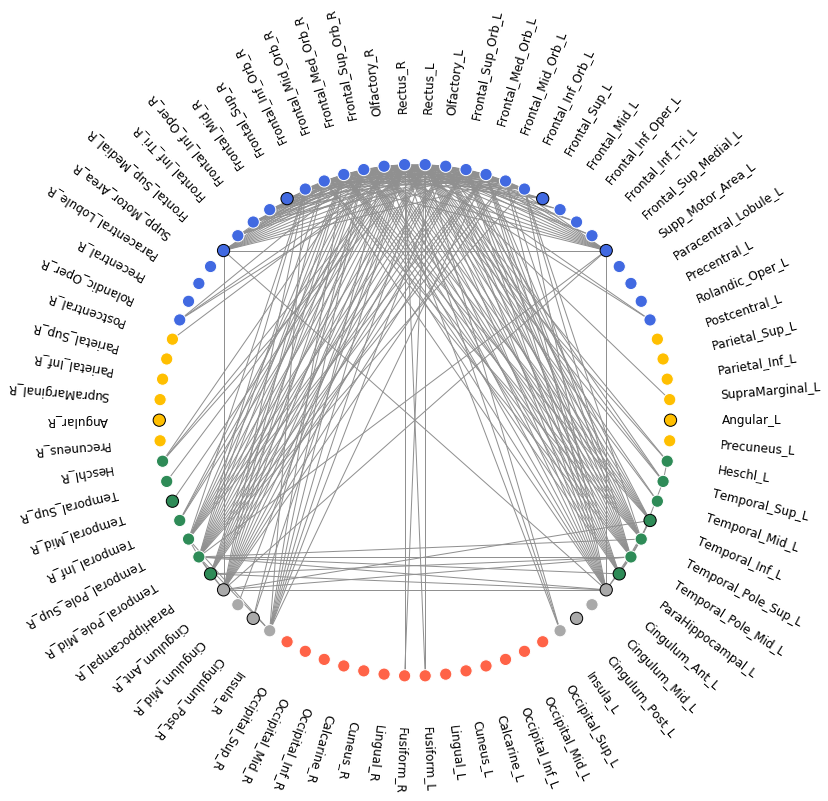

In [116]:
AAL.drawgraph(AAL.SC,weigh)

# 1.4) Example of binary FUN and SUN

In [1085]:
BinEminima_fast=np.zeros(nedges)
BinEminima_fast[np.where(EminimaNew<7.2)]=1

In [1086]:
tri = np.zeros((78, 78))
tri[np.triu_indices(78, 1)] = BinEminima_fast
MiniMat_fast=tri+tri.T

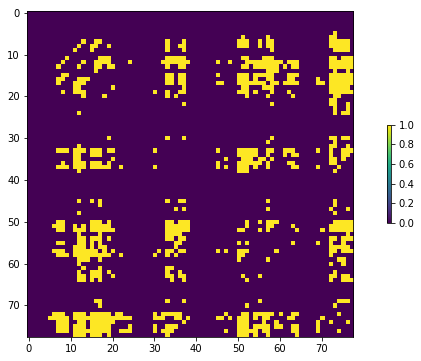

In [1087]:
plt.figure(figsize=(12,6))
plt.imshow((MiniMat_fast));plt.colorbar(shrink=0.3)

In [1091]:
BinEminima_slow=np.zeros(nedges)
BinEminima_slow[np.where(EminimaNew>9.5)]=1

In [1092]:
tri = np.zeros((78, 78))
tri[np.triu_indices(78, 1)] = BinEminima_slow
MiniMat_slow=tri+tri.T

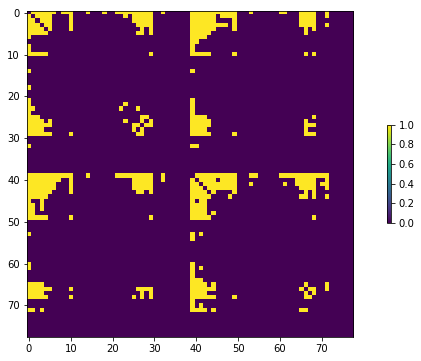

In [1093]:
plt.figure(figsize=(12,6))
plt.imshow((MiniMat_slow));plt.colorbar(shrink=0.3)

# 1.5) Typical Decay Mutual Information

## - same subject, same edge, in 10 different windows

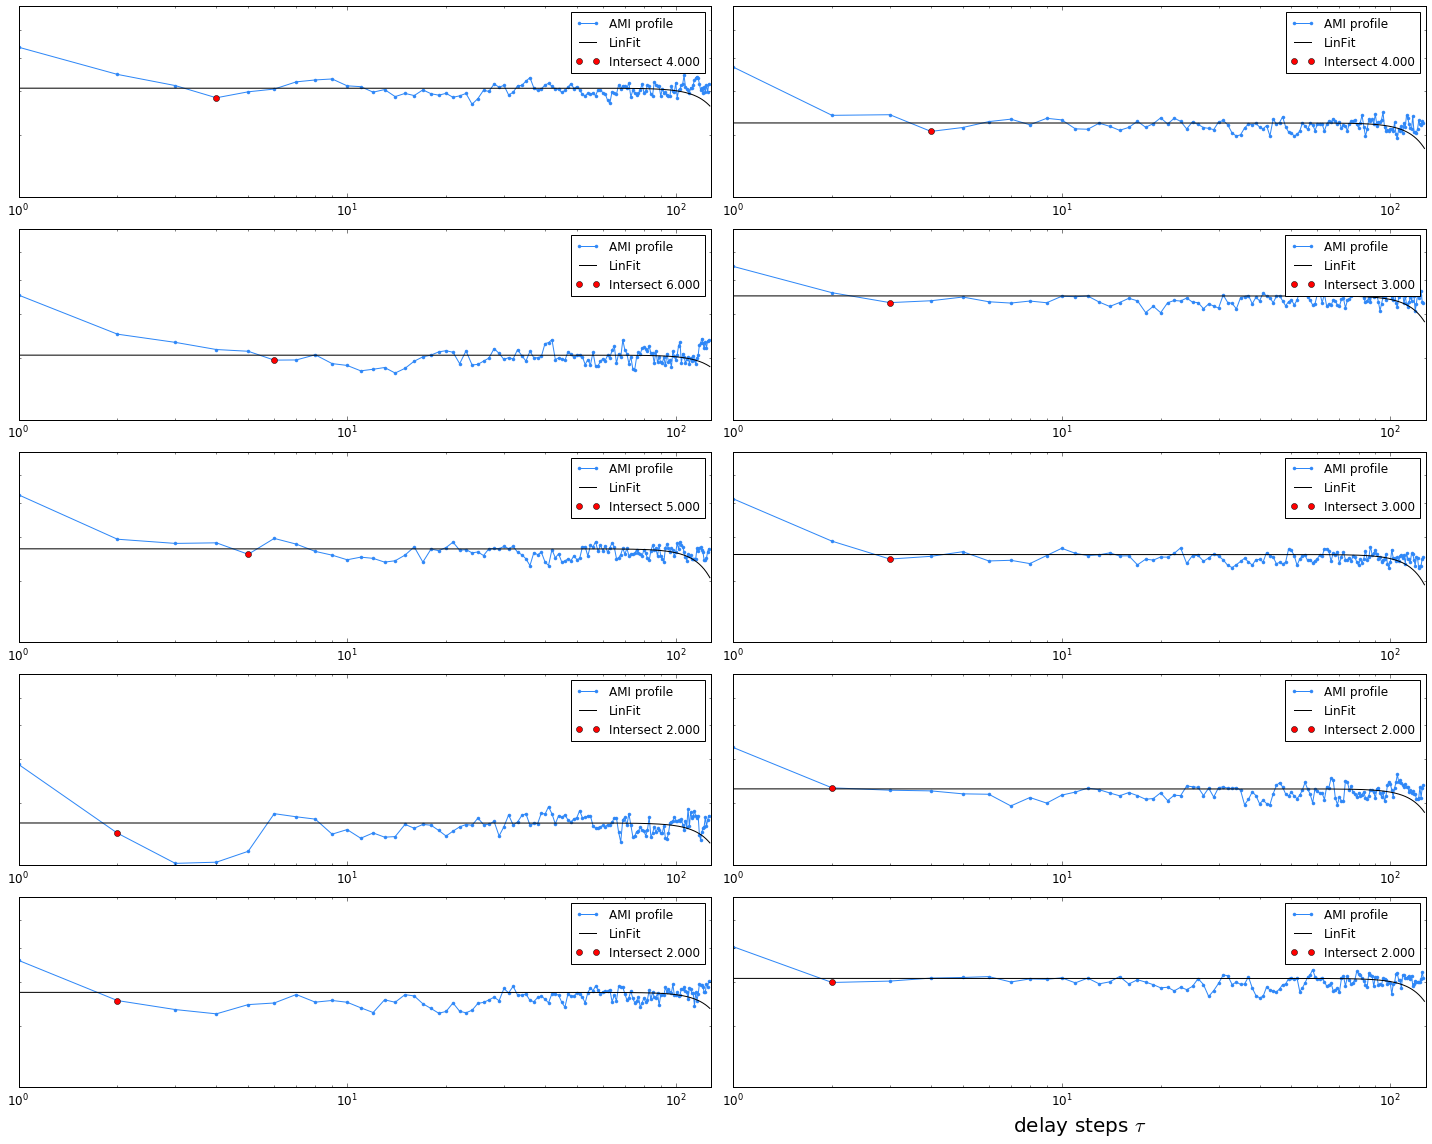

In [118]:
ee=156
sb=7
#iw=0
plt.figure(figsize=(20,16))

for iww in range(10):
    plt.subplot(5,2,iww+1)
    numero3=MIS_edges['%d'%sb][iww][:,ee]
    denumero3=np.max(MIS_edges['%d'%sb][iww][:,ee])
    # single edge normalized MIS
    y3=numero3/denumero3
    opt3, pcov3 = curve_fit(model_func_lin, x2[50:], y3[50:], p1)
    a3, b3 = opt3

    #plt.title('Auto Mutual Information \n',fontsize=26)
    plt.loglog(y3,'.-',color=([0.1785, 0.5296, 0.9677]),label='AMI profile')
    x2 = np.linspace(0, 127, 128)
    g=model_func_lin(x2, a3, b3)
    plt.loglog(x2,g,'k-',label='LinFit')
    idx = np.argwhere(y3 - g<0.005).flatten()
    plt.loglog(x2[idx[0]], y3[idx[0]], 'ro',label='Intersect %.3f'%x2[idx[0]])
    plt.ylim((0.2,0.7))
    plt.xlim((0.,128))
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend()
    #plt.show()
plt.xlabel('delay steps $\\tau$',fontsize=20)
plt.tight_layout()
plt.show()

Text(0.5,0,'delay steps $\\tau$')

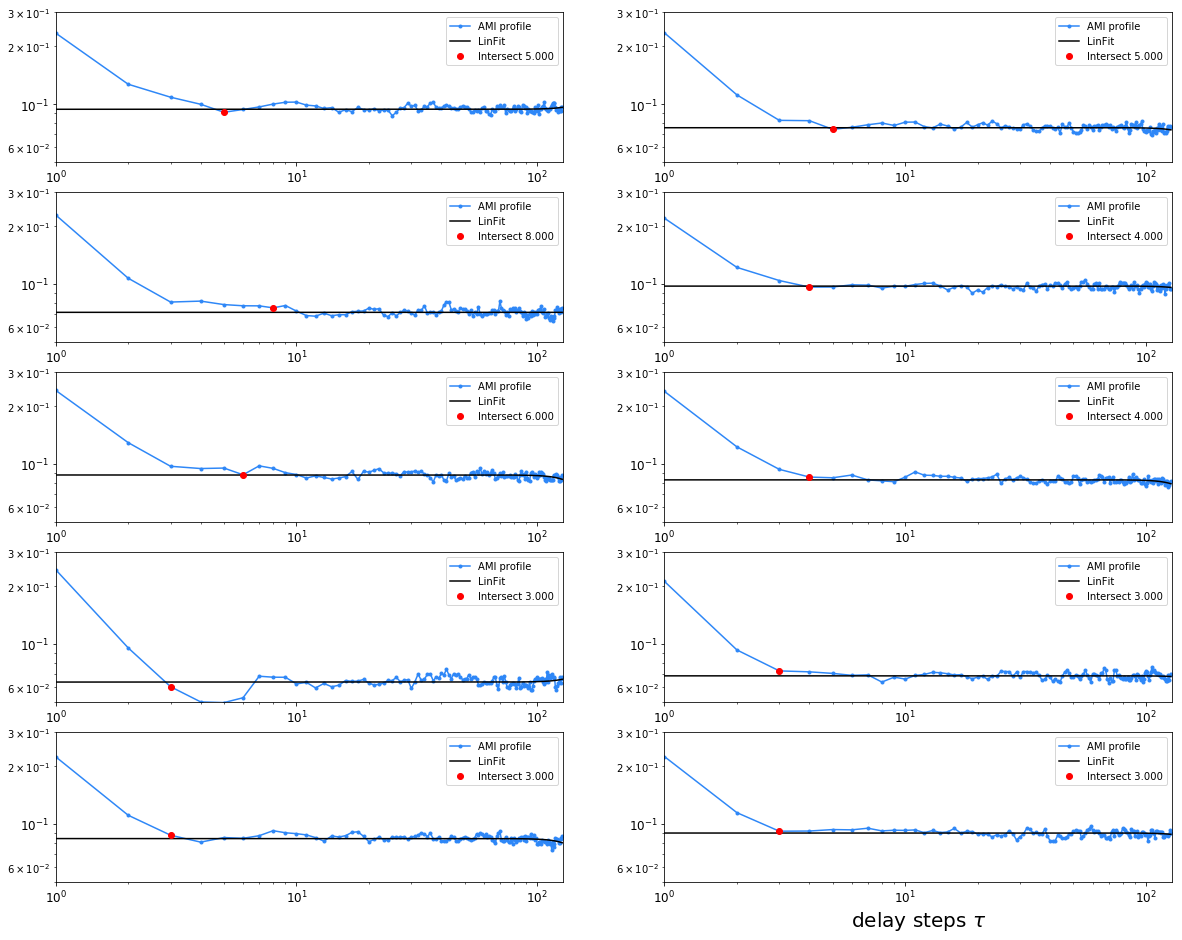

In [118]:
ee=156
sb=7
#iw=0
plt.figure(figsize=(20,16))

for iww in range(10):
    plt.subplot(5,2,iww+1)
    numero3=MIS_edges['%d'%sb][iww][:,ee]
    denumero3=np.max(MIS_edges['%d'%sb][iww][:,ee])
    # single edge normalized MIS
    y3=numero3/denumero3
    opt3, pcov3 = curve_fit(model_func_lin, x2[50:], y3[50:], p1)
    a3, b3 = opt3

    #plt.title('Auto Mutual Information \n',fontsize=26)
    plt.loglog(y3,'.-',color=([0.1785, 0.5296, 0.9677]),label='AMI profile')
    x2 = np.linspace(0, 127, 128)
    g=model_func_lin(x2, a3, b3)
    plt.loglog(x2,g,'k-',label='LinFit')
    idx = np.argwhere(y3 - g<0.005).flatten()
    plt.loglog(x2[idx[0]], y3[idx[0]], 'ro',label='Intersect %.3f'%x2[idx[0]])
    plt.ylim((0.5e-1,0.3))
    plt.xlim((0.,128))
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend()
    #plt.show()
plt.xlabel('delay steps $\\tau$',fontsize=20)

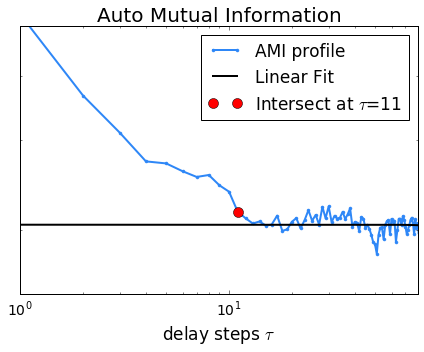

In [154]:
sb=2
iw=5
thresh=np.linspace(1,6.,11)
plt.figure(figsize=(6,5))
x = np.linspace(0., 127., 128)
x2 = np.linspace(0., 127., 128)
p1=(0.,0.)
ie=6
numero3=MIS_edges['%d'%sb][iw][:,ie]
denumero3=np.max(MIS_edges['%d'%sb][iw][:,ie])
# single edge normalized MIS
y3=numero3/denumero3
opt3, pcov3 = curve_fit(model_func_lin, x2[50:], y3[50:], p1)
a3, b3 = opt3

#plt.title('Auto Mutual Information \n',fontsize=26)
plt.loglog(y3,'.-',linewidth=2,color=([0.1785, 0.5296, 0.9677]),label='AMI profile')
x2 = np.linspace(0, 127, 128)
g=model_func_lin(x2, a3, b3)
plt.loglog(x2,g,'k-',linewidth=2,label='Linear Fit')
idx = np.argwhere(np.abs(y3 - g)<1*np.std(y3[50:])).flatten()
plt.loglog(x2[idx[0]], y3[idx[0]], 'ro',markersize=10,label='Intersect at $\\tau$=%d'%x2[idx[0]])
plt.ylim((0.15,0.5))
plt.xlim((0.,80))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Auto Mutual Information',fontsize=20)
plt.legend(fontsize=17)
#plt.show()
plt.xlabel('delay steps $\\tau$',fontsize=17)
plt.tight_layout()
plt.savefig('AMIfig1.pdf')
plt.show()

## same subject, same windows, in 9 different edges

Text(0.5,0,'delay steps $\\tau$')

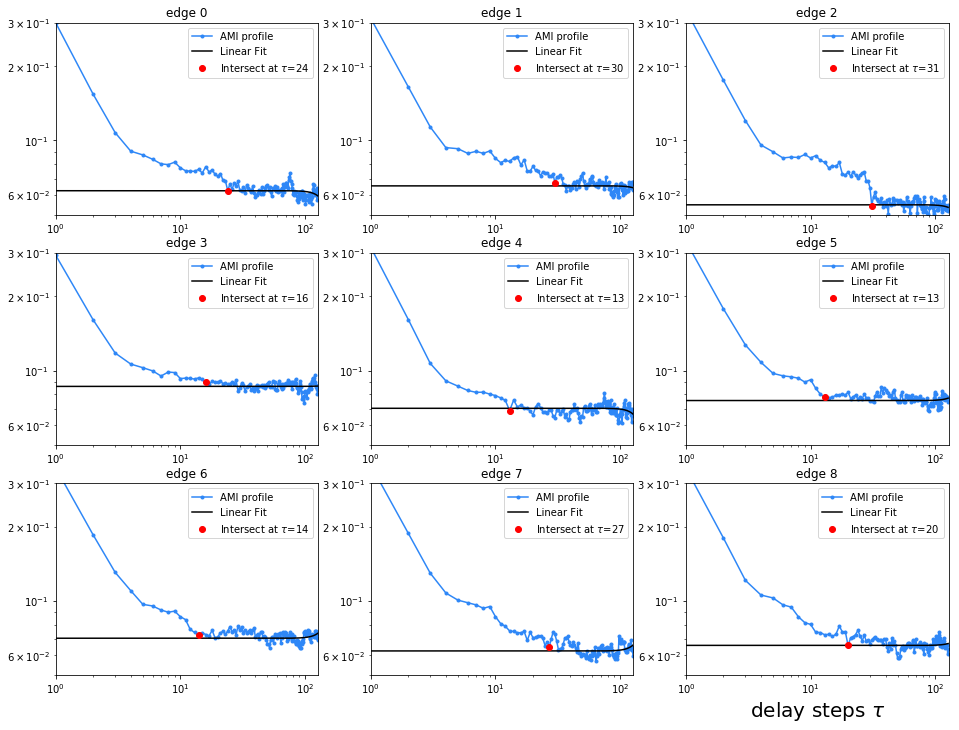

In [121]:
sb=2
iw=5
thresh=np.linspace(1,6.,11)
plt.figure(figsize=(16,12))
x = np.linspace(0., 127., 128)
x2 = np.linspace(0., 127., 128)
p1=(0.,0.)

for ie in np.arange(9):
    plt.subplot(3,3,ie+1)
    numero3=MIS_edges['%d'%sb][iw][:,ie]
    denumero3=np.max(MIS_edges['%d'%sb][iw][:,ie])
    # single edge normalized MIS
    y3=numero3/denumero3
    opt3, pcov3 = curve_fit(model_func_lin, x2[50:], y3[50:], p1)
    a3, b3 = opt3

    #plt.title('Auto Mutual Information \n',fontsize=26)
    plt.loglog(y3,'.-',color=([0.1785, 0.5296, 0.9677]),label='AMI profile')
    x2 = np.linspace(0, 127, 128)
    g=model_func_lin(x2, a3, b3)
    plt.loglog(x2,g,'k-',label='Linear Fit')
    idx = np.argwhere(np.abs(y3 - g)<1*np.std(y3[50:])).flatten()
    plt.loglog(x2[idx[0]], y3[idx[0]], 'ro',label='Intersect at $\\tau$=%d'%x2[idx[0]])
    plt.ylim((0.5e-1,0.3))
    plt.xlim((0.,128))
    plt.title('edge %d'%ie)
    plt.legend()
    #plt.show()
plt.xlabel('delay steps $\\tau$',fontsize=20)

## same subject, same windows, same edge, different threshold values

Text(0.5,0,'delay steps $\\tau$')

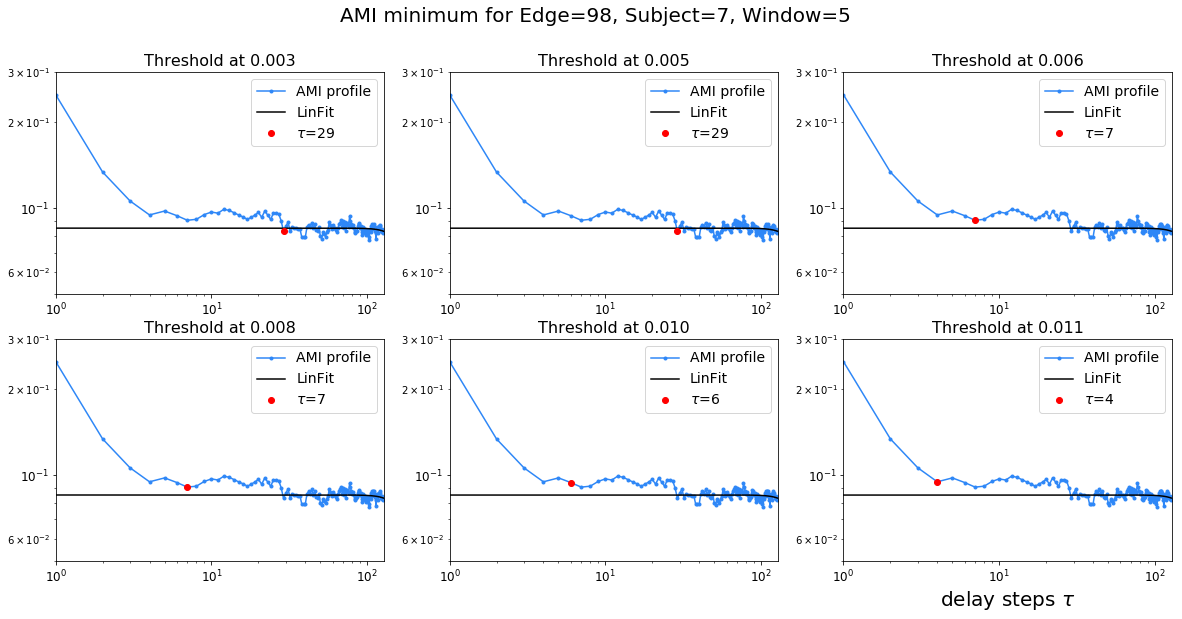

In [122]:
ee=98
sb=7
iw=5
thresh=np.linspace(1,6.,11)
plt.figure(figsize=(20,9))
x = np.linspace(0., 127., 128)
x2 = np.linspace(0., 127., 128)
p1=(0.,0.)
plt.suptitle('AMI minimum for Edge=98, Subject=7, Window=5',fontsize=20)
for iww,ww in enumerate(thresh[:-5]):
    plt.subplot(2,3,iww+1)
    numero3=MIS_edges['%d'%sb][iw][:,ee]
    denumero3=np.max(MIS_edges['%d'%sb][iw][:,ee])
    # single edge normalized MIS
    y3=numero3/denumero3
    opt3, pcov3 = curve_fit(model_func_lin, x2[50:], y3[50:], p1)
    a3, b3 = opt3

    #plt.title('Auto Mutual Information \n',fontsize=26)
    plt.loglog(y3,'.-',color=([0.1785, 0.5296, 0.9677]),label='AMI profile')
    x2 = np.linspace(0, 127, 128)
    g=model_func_lin(x2, a3, b3)
    plt.loglog(x2,g,'k-',label='LinFit')
    idx = np.argwhere(np.abs(y3 - g)<ww*np.std(y3[50:])).flatten()
    plt.loglog(x2[idx[0]], y3[idx[0]], 'ro',label='$\\tau$=%d'%x2[idx[0]])
    plt.ylim((0.5e-1,0.3))
    plt.xlim((0.,128))
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=14)
    plt.title('Threshold at %.3f'%(ww*np.std(y3[50:])),fontsize=16)
    #plt.show()
plt.xlabel('delay steps $\\tau$',fontsize=20)

# 1.6) Variance, Structure, FC and Mean do not correlate with AMI decay times

In [126]:
nsub=44
nedges=int(nregions**2/2-nregions/2)
ntwin=10
VAR_e=np.zeros((nsub, ntwin, nedges))
MEAN_e=np.zeros((nsub,ntwin, nedges))
FC_e=np.zeros((nsub,ntwin, nedges))
fastpool=[]
for i, sub in enumerate(np.where(nwinds>=ntwin)[0]):
    for iw in range(ntwin):
        megwin=consecutives['%d'%sub][iw][:,AAL.Neword_lab]
        fc=np.corrcoef(megwin.T)
        Zmeg=stats.zscore(megwin,axis=0)
        Edges=Zmeg[:,iTriup[0]]*Zmeg[:,iTriup[1]]
        VAR_e[i][iw]=np.var(Edges,axis=0)
        MEAN_e[i][iw]=np.mean(Edges,axis=0)
        FC_e[i][iw]=fc[np.triu_indices(78, 1)]

In [131]:
var_e=np.mean(np.mean(VAR_e,axis=0),axis=0)
mean_e=np.mean(np.mean(MEAN_e,axis=0),axis=0)
fc_e=np.mean(np.mean(FC_e,axis=0),axis=0)
SCarrNew=SCs[np.triu_indices(78, 1)]

In [132]:
tri = np.zeros((78, 78))
tri[np.triu_indices(78, 1)] = var_e
VarMatNew=tri+tri.T
tri = np.zeros((78, 78))
tri[np.triu_indices(78, 1)] = mean_e
MeanMatNew=tri+tri.T
tri = np.zeros((78, 78))
tri[np.triu_indices(78, 1)] = fc_e
FC=tri+tri.T

In [133]:
np.corrcoef(EminimaNew,var_e)

array([[1.        , 0.38705216],
       [0.38705216, 1.        ]])

In [134]:
np.corrcoef(EminimaNew,mean_e)

array([[1.        , 0.19613338],
       [0.19613338, 1.        ]])

In [135]:
np.corrcoef(EminimaNew,SCarrNew)

array([[1.        , 0.00714812],
       [0.00714812, 1.        ]])

In [136]:
np.corrcoef(var_e,mean_e)

array([[1.        , 0.61318381],
       [0.61318381, 1.        ]])

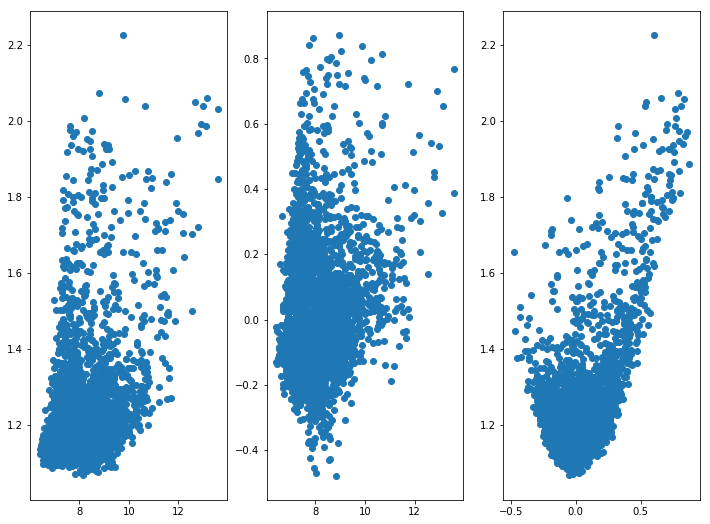

In [137]:
plt.figure(figsize=(12,9))
plt.subplot(131);plt.scatter(EminimaNew,var_e)
plt.subplot(132);plt.scatter(EminimaNew,mean_e)
plt.subplot(133);plt.scatter(mean_e,var_e)


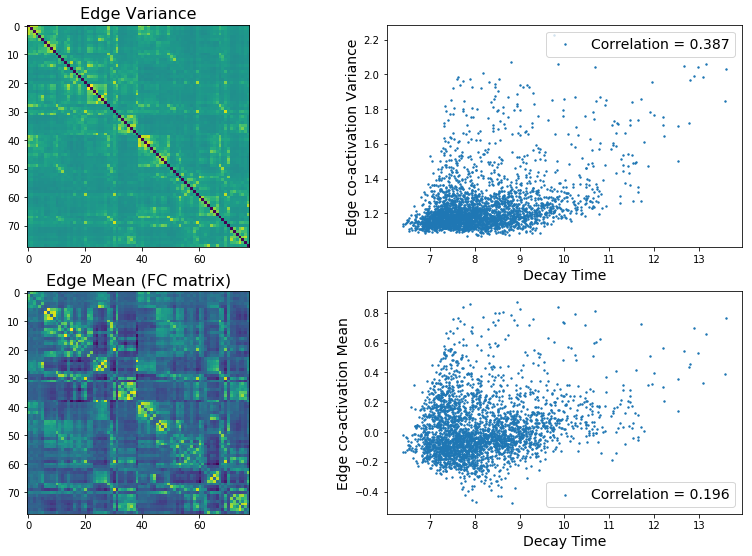

In [138]:
plt.figure(figsize=(14,9))
plt.subplot(221);plt.imshow(VarMatNew);plt.title('Edge Variance',fontsize=16)
plt.subplot(222);plt.scatter(EminimaNew,var_e,s=2,label='Correlation = %.3f'%(np.corrcoef(EminimaNew,var_e)[0,1]));plt.xlabel('Decay Time',fontsize=14);plt.ylabel('Edge co-activation Variance',fontsize=14)
plt.legend(fontsize=14)
plt.subplot(223);plt.imshow(MeanMatNew);plt.title('Edge Mean (FC matrix)',fontsize=16)
plt.subplot(224);plt.scatter(EminimaNew,mean_e,s=2,label='Correlation = %.3f'%(np.corrcoef(EminimaNew,mean_e)[0,1]));plt.xlabel('Decay Time',fontsize=14);plt.ylabel('Edge co-activation Mean',fontsize=14)
plt.legend(fontsize=14)
plt.show()


# APPENDIX: Check the results with 'old' order and find single subject examples

In [ ]:
#The first minima of the mutual information score beteewn each region and its time lagged version form a multimodal distribution.
#Frontal nodes have minima occurring at later times. Information is preserved for longer times.
nedges=int(nregions**2/2-nregions/2)
tau_max = 128 
ntwin=10
nbin=64
MIS_edges={}
for i, sub in enumerate(np.where(nwinds>=ntwin)[0]):
    EMIS_wind=np.zeros((ntwin, tau_max, nedges))
    for iw in range(ntwin):
        megwin=consecutives['%d'%sub][iw][:,:] #AAL.Neword_lab
        Zmeg=stats.zscore(megwin,axis=0)
        Edges=Zmeg[:,iTriup[0]]*Zmeg[:,iTriup[1]]
        EMIS_wind[iw]=TDE.TauLag(Edges, tau_max, nedges, 'MI', nbin)
    MIS_edges['%d'%i]=EMIS_wind

In [ ]:
#save_obj(MIS_edges,'MIS_edges_oldord')

In [20]:
minima_edges_Single=np.zeros((44,10,nedges))
minima_edges_Single_int=np.zeros((44,10,nedges))
x = np.linspace(0., 127., 128)
p1=(0.,0.)
x2 = np.linspace(0., 127., 128)

for i in range(44):
    for j in range(10):
        for ie in range(nedges):
            numero=MIS_edges['%d'%i][j][:,ie]
            denumero=np.max(MIS_edges['%d'%i][j][:,ie])
            y=numero/denumero
            # curve fit
            opt1, pcov1 = curve_fit(model_func_lin, x[30:], y[30:], p1)
            a1, b1 = opt1
            
            g=model_func_lin(x, a1, b1)
            idx = np.argwhere(y - g<0.005).flatten()
            
            minima_edges_Single[i][j,ie]=x[idx[0]]  
            minima_edges_Single_int[i][j,ie]=trapz(y[:int(x[idx[0]])], dx=1) 

In [24]:
minima_edges_Single.shape

(44, 10, 3003)

In [21]:
minima_edges=np.mean(minima_edges_Single,axis=1)
Eminima=np.mean(minima_edges,axis=0)
tri = np.zeros((78, 78))
tri[np.triu_indices(78, 1)] = Eminima
MiniMat=tri+tri.T

Text(0,0.5,'ROIs')

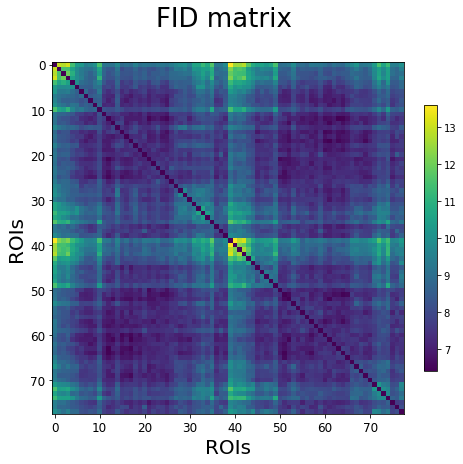

In [22]:
plt.figure(figsize=(7,7))
plt.title('FID matrix \n',fontsize=26)
#plt.subplot(121);plt.imshow(MiniMat,vmin=6.5);plt.colorbar(shrink=0.3)
plt.imshow(MiniMat,vmin=np.sort(np.unique(MiniMat))[1]);
cb = plt.colorbar(shrink=0.7,fraction=0.05)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('ROIs',fontsize=20)
plt.ylabel('ROIs',fontsize=20)

# Single Subject Analyis. 

In [80]:
FUNsingle=np.zeros((44, 10, nregions,nregions))
SUNsingle=np.zeros((44, 10, nregions,nregions))
for i in range(44):
    for j in range(10):
        quart1=np.percentile(minima_edges_Single[i,j,:],25,interpolation='midpoint')
        quart4=np.percentile(minima_edges_Single[i,j,:],75,interpolation='midpoint')
        FEmin=np.where(minima_edges_Single[i,j,:]<=quart1,1,0)
        tri = np.zeros((78, 78))
        tri[np.triu_indices(78, 1)] = FEmin
        FUNsingle[i,j,:,:]=tri+tri.T
        
        SEmin=np.where(minima_edges_Single[i,j,:]>=quart4,1,0)
        tri = np.zeros((78, 78))
        tri[np.triu_indices(78, 1)] = SEmin
        SUNsingle[i,j,:,:]=tri+tri.T
# path='/home/giovanni.rabuffo/Neural_Data/Pierpaolo_MEG'
# io.savemat(path+'/ArticleResults_I/FUNepochs.mat', {'C':FUNsingle})
# io.savemat(path+'/ArticleResults_I/SUNepochs.mat', {'C':SUNsingle})

# Rank Single Subject ???

In [151]:
SubjectRank=np.zeros((44,78))
for i in range(44):
    tri = np.zeros((78, 78))
    tri[np.triu_indices(78, 1)] = np.mean(minima_edges_Single,axis=1)[i]
    SubjectRank[i,:]=np.sum((tri+tri.T)/np.max(tri+tri.T),axis=0)
    

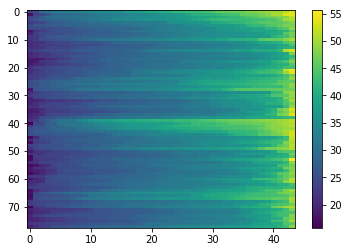

In [157]:
plt.imshow(np.sort(SubjectRank.T,axis=1),aspect='auto');
plt.colorbar()

In [158]:
SubjectRank_e=np.zeros((44,nedges))
for i in range(44):
    SubjectRank_e[i,:]=np.mean(minima_edges_Single,axis=1)[i]/np.max(np.mean(minima_edges_Single,axis=1)[i])

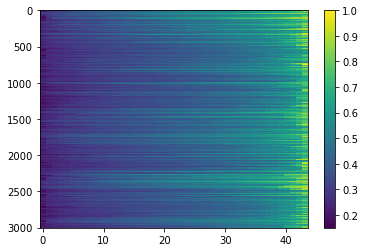

In [159]:
plt.imshow(np.sort(SubjectRank_e.T,axis=1),aspect='auto');
plt.colorbar()